# Train Baseline CNN/CapsNet on MNIST, then generate adv examples

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import torch
from torch import optim

from datasets import get_mnist_dataset, get_data_loader
from utils import *

from cnn import *
from capsnet import *

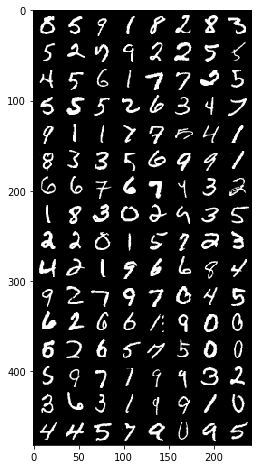

In [4]:
trainset, testset = get_mnist_dataset()
trainloader, testloader = get_data_loader(trainset, testset)
batch, labels = next(iter(trainloader))
plot_batch(batch)
batch_var = Variable(batch.cuda())
labels_var = Variable(one_hotify(labels).cuda())

# Custom tiny CNN

In [54]:
tiny_model = CNN().cuda()
print(count_params(tiny_model))

tiny_optimizer = optim.Adam(tiny_model.parameters())
tiny_loss = nn.CrossEntropyLoss()
tiny_trainer = Trainer(tiny_model, tiny_optimizer, tiny_loss,
                       trainloader, testloader, use_cuda=True)

246506


In [55]:
tiny_trainer.run(epochs=5)

[*] Training for 5 epochs
[*] Epoch 1, TrnLoss: 0.123, TrnAcc: 0.964, TstLoss: 0.045, TstAcc: 0.986
[*] Epoch 2, TrnLoss: 0.036, TrnAcc: 0.989, TstLoss: 0.032, TstAcc: 0.988
[*] Epoch 3, TrnLoss: 0.025, TrnAcc: 0.992, TstLoss: 0.026, TstAcc: 0.991
[*] Epoch 4, TrnLoss: 0.021, TrnAcc: 0.993, TstLoss: 0.038, TstAcc: 0.988
[*] Epoch 5, TrnLoss: 0.015, TrnAcc: 0.995, TstLoss: 0.040, TstAcc: 0.988


# Baseline CNN described in [1]

In [47]:
base_model = BaselineCNN().cuda()
print(count_params(base_model))

base_loss = nn.CrossEntropyLoss()
base_optimizer = optimizer = optim.Adam(base_model.parameters())
base_trainer = Trainer(base_model, base_optimizer, base_loss,
                       trainloader, testloader, use_cuda=True,
                       print_every=50)

35445522


In [48]:
base_trainer.run(epochs=1)

[*] Training for 1 epochs
[*] Batch 0, Loss: 2.318, Acc: 0.070
[*] Batch 50, Loss: 0.316, Acc: 0.938
[*] Batch 100, Loss: 0.104, Acc: 0.969
[*] Batch 150, Loss: 0.158, Acc: 0.953
[*] Batch 200, Loss: 0.115, Acc: 0.953
[*] Batch 250, Loss: 0.038, Acc: 1.000
[*] Batch 300, Loss: 0.108, Acc: 0.969
[*] Batch 350, Loss: 0.056, Acc: 0.977
[*] Batch 400, Loss: 0.054, Acc: 0.961
[*] Batch 450, Loss: 0.031, Acc: 0.984
[*] Batch 0, Loss: 0.016, Acc: 0.992
[*] Batch 50, Loss: 0.038, Acc: 0.992
[*] Epoch 1, TrnLoss: 0.242, TrnAcc: 0.925, TstLoss: 0.049, TstAcc: 0.985


# CapsNet described in [1]

In [5]:
net = CapsuleNetwork().cuda()
decoder = CapsuleDecoder(reconstruction=True, mask_incorrect=True).cuda()
class CapsModel(nn.Module):
    def __init__(self, net, decoder):
        super().__init__()
        self.net = net
        self.decoder = decoder
    
    def forward(self, x, y=None):
        d_caps = self.net(x)
        probs, reconstructions = self.decoder(d_caps, y)
        return probs, reconstructions
caps_model = CapsModel(net, decoder)

print(count_params(net))
print(count_params(caps_model))

caps_loss = CapsuleLoss(rcsn_scale=0.005)
caps_optimizer = optim.Adam(caps_model.parameters())
caps_trainer = Trainer(caps_model, caps_optimizer, caps_loss,
                       trainloader, testloader,
                       one_hot=True, use_reconstructions=True, use_cuda=True,
                       print_every=50)

6804224
8215568


In [6]:
MODEL_PATH = 'capsnet_mnist.pth.tar'

In [ ]:
caps_trainer.load_checkpoint('trained_capsnet.pth.tar')
caps_trainer.run(epochs=4)
caps_trainer.save_checkpoint(MODEL_PATH)

[*] Training for 4 epochs
[*] Batch 0, Loss: 74.053, Acc: 0.984
[*] Batch 50, Loss: 72.543, Acc: 1.000


In [7]:
caps_trainer.load_checkpoint(MODEL_PATH)

## Reconstructions

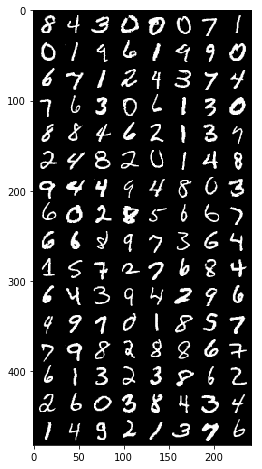

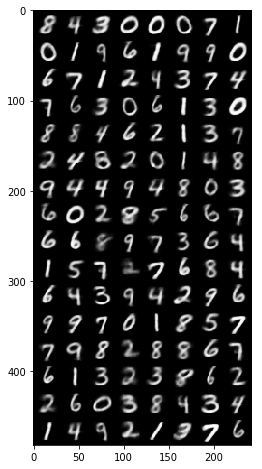

In [8]:
probs, batch_hat = caps_model(batch_var, Variable(one_hotify(labels).cuda()))
plot_batch(batch)
plot_batch(batch_hat.data)

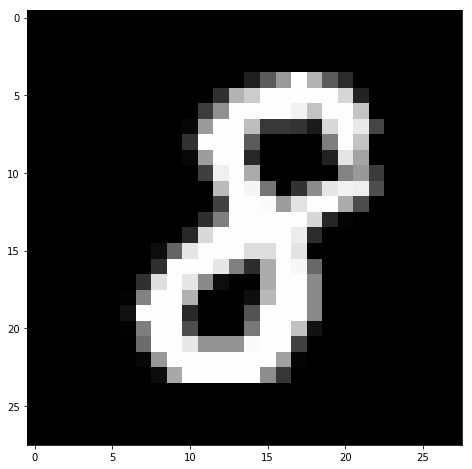

In [10]:
seed_img = batch[0:1]
plot_tensor(seed_img)

In [44]:
from adversarial import Adversary

class CapsuleLogits(nn.Module):
    
    def __init__(self, caps_net):
        super().__init__()
        self.caps_net = caps_net

    def forward(self, x):
        d_caps = self.caps_net(x)
        logits = torch.norm(d_caps, dim=-1)
        return logits

caps_logits = CapsuleLogits(net)
caps_adversary = Adversary(caps_logits)
fool_img = caps_adversary.generate_example(seed_img.cuda(), attack='FGS',
                                           target=2, ground=8, eta=0.0002, n_iters=1000)

In [87]:
base_adversary = Adversary(base_model)
fool_img = base_adversary.generate_example(seed_img.cuda(), attack='FGS',
                                           target=2, ground=8, eta=0.00005, n_iters=10000)

In [71]:
tiny_adversary = Adversary(tiny_model)
fool_img = tiny_adversary.generate_example(seed_img.cuda(), attack='FGS',
                                           target=None, ground=8, eta=0.0002, n_iters=2000)

In [75]:
probs_seed = tiny_model(Variable(seed_img).cuda())
probs_fool = tiny_model(Variable(fool_img).cuda())
print(probs_seed.data.cpu().numpy())
print(probs_fool.data.cpu().numpy())

probs_seed = base_model(Variable(seed_img).cuda())
probs_fool = base_model(Variable(fool_img).cuda())
print(probs_seed.data.cpu().numpy())
print(probs_fool.data.cpu().numpy())

[[ -1.0639179  -5.500822    1.1167443   4.3614616  -5.531336   -3.6035335
   -5.7011847 -11.295701   17.544317    1.520819 ]]
[[-3.0111709 -6.4659963  5.892588   1.3561507  2.7954953 -7.777596
  -5.072394  -6.232225  14.467915   0.6591921]]
[[-0.10174463 -1.3642561  -0.18236588 -0.99546623 -5.263164   -2.3804703
  -1.8678036  -2.843044    8.951306   -2.459402  ]]
[[-2.0146356  -0.73223084  7.1779594   2.1735854  -3.1366234  -6.1903844
  -2.6100397  -0.7889816   1.0118126  -3.1610057 ]]


Variable containing:
 0.0854  0.0858  0.0854  0.0854  0.0854  0.0855  0.0855  0.0854  0.2309  0.0854
[torch.cuda.FloatTensor of size 1x10 (GPU 0)]

Variable containing:
 0.0930  0.0921  0.1362  0.0924  0.0928  0.0967  0.0924  0.0936  0.1181  0.0926
[torch.cuda.FloatTensor of size 1x10 (GPU 0)]



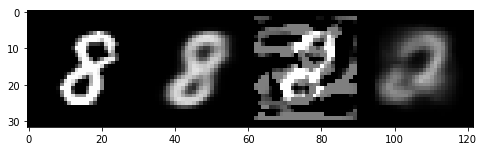

In [88]:
probs_seed, rec_seed = caps_model(Variable(seed_img).cuda())
probs_fool, rec_fool = caps_model(Variable(fool_img).cuda())
rec_seed = rec_seed.data.cpu()
rec_fool = rec_fool.data.cpu()

print(probs_seed)
print(probs_fool)
plot_batch(torch.cat([seed_img, rec_seed, fool_img, rec_fool]))

### References

[1] https://arxiv.org/abs/1710.09829